# Google Stock Prediction

# Rup Patel, Damel Albertos, Joel Jerez

### Problem Introduction
#### The stock market is the aggregation of buyers and sellers of stocks (shares) represents some ownership for a business or corporation. This can include public or privately traded company and many use this as a way to invest into their future. There are many different stocks out on the market today; One of the most prestigious companies and stock out that is publicly traded is Google. The purpose of this project is to see if we can create a model to help us accurately predict Google's stock price and use the model as a method of evaluation for our next investment. 

### Proposed Solution
#### Based on the randomness of stocks, we decided to use two different models to see which can perform the best at determining the stock prices. The first model will be an Long short-term memory (LSTM) model which can store data for longer while using the output and input in the next input. We also decided to use Linear Regression as well since this would be a straight forward approach to the problem. Based on our test data only including 20 days, we decided to take it a step further for another LSTM model to split up training and test data by only using the training data. This would give us the prediction for the stock price for about 148 days; which would be much more realistic and accurate since most people tend to keep their money in stocks longer than 20 days. 

### Source

#### We got this data set from Kaggle which includes a training set with 1258 days of the stock price from the beginning of 2012 up until the end of 2016. The test file has the stock prices for 20 days in January 2017 which we will use to test. The files come with 6 main features that include the Date, Open, High, Low, Close and Volume.

### Import Necessary Libraries we will be using

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn import metrics

## Create our training set and Model (SETUP)

#### Select columns we want to use; in this model we decided to only use the Open column which contained the price the stock opened at for that day. We iterate through and begin creating our training sets for X and y. One we have our training set scaled and into an numpy array we can begin creating our LSTM model. 

In [2]:
#import training set
train_data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)

#select column values we want to include
training_set = train_data.iloc[:,1:2].values

training_set


array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [3]:
#feature scaling to give us values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0,1))

#fit the data
train_set_sc = scaler.fit_transform(training_set)


In [4]:
X_train=[]
y_train = []
n=60

#create training sets with timesteps

for i in range(n,len(train_set_sc)):
    X_train.append(train_set_sc[i-n: i,0])
    y_train.append(train_set_sc[i,0])



In [5]:
#Make them into np array 
X_train, y_train = np.array(X_train), np.array(y_train)


#Reshape so we have our correct dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#dimension is 3
X_train.shape

(1198, 60, 1)

# LSTM MODEL

In [6]:
reg = Sequential()
#Units determines our input layers
reg.add(LSTM(units = 50,return_sequences = True,  input_shape=(X_train.shape[1], 1)))
#Drop out means what % of NN neurons 
reg.add(Dropout(0.2))


#Second LSTM Layer
reg.add(LSTM(units = 50, return_sequences = True))
reg.add(Dropout(0.3))

# Third LSTM Layer
reg.add(LSTM(units = 50, return_sequences = True))
reg.add(Dropout(0.4))

# Fourth LSTM Layer
reg.add(LSTM(units = 50))
reg.add(Dropout(0.5))


# The output layer
reg.add(Dense(units = 1))





             

In [7]:
reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [8]:
reg.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [9]:
reg.fit(X_train, y_train, epochs=10,batch_size=32)

Epoch 1/10
38/38 [==============================] - 3s 82ms/step - loss: 0.0588 - accuracy: 0.0017
Epoch 2/10
38/38 [==============================] - 3s 72ms/step - loss: 0.0141 - accuracy: 0.0017
Epoch 3/10
38/38 [==============================] - 3s 69ms/step - loss: 0.0116 - accuracy: 0.0017
Epoch 4/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0117 - accuracy: 0.0017
Epoch 5/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0117 - accuracy: 0.0017
Epoch 6/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0122 - accuracy: 0.0017
Epoch 7/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0115 - accuracy: 0.0017
Epoch 8/10
38/38 [==============================] - 5s 125ms/step - loss: 0.0087 - accuracy: 0.0017
Epoch 9/10
38/38 [==============================] - 5s 135ms/step - loss: 0.0091 - accuracy: 0.0017
Epoch 10/10
38/38 [==============================] - 5s 137ms/step - loss: 0.0092 - accuracy: 0.0017


## PREP TEST DATA TO COMPARE

#### Follow same process as the training set only this time we use test set and make sure we get the correct input shape.

In [10]:
test_data = pd.read_csv("Google_Stock_Price_Test.csv")

test_set = test_data.iloc[:, 1:2].values


In [11]:
#Get predicted stock price in January 2017 for our 20 days 
#concat the open column for both training and testdata
data_total = pd.concat((train_data['Open'], test_data['Open']), axis=0)

#get right amount of inputs
inputs=data_total[len(train_data) - len(test_data) - 60:].values

#reshape to fix 
inputs= inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

inputs.shape[0]

100

In [12]:
#Get our test set values from 

X_test = []
y_test = []


for i in range(80, inputs.shape[0]):
    X_test.append(inputs[i-n:i,0])


In [13]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

X_test.shape


(20, 60, 1)

In [14]:
y_pred = reg.predict(X_test)


In [15]:
y_pred = scaler.inverse_transform(y_pred)

## VISUALIZE RESULTS

#### Results here aren't too bad; As we can see through the plot that we had slow, constance increase in our prediction price while the real stock price continuously increased then decreased. Overall I would say for a short 20 days, this model is fairly accurate. 

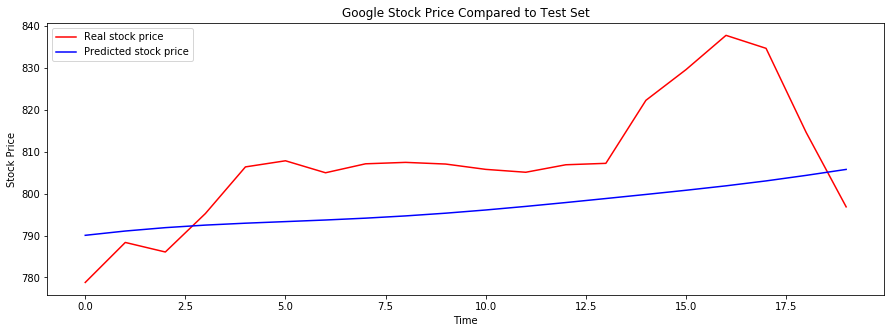

In [16]:
#Visualize Results
plt.figure(figsize=(15,5))
plt.plot(test_set, color='red', label = "Real stock price")
plt.plot(y_pred, color='blue', label = "Predicted stock price")
plt.title("Google Stock Price Compared to Test Set")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Linear Regression

## Setup

#### We want to read in both of our files and create our training and test sets. This time, instead of using just the Open column, we decided to go ahead and use all the columns in our model to see if that gives us a better prediction. 

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [18]:
tr_data = train_data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)
tr_data.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0


In [19]:
tst_data = pd.read_csv('Google_Stock_Price_Test.csv', date_parser = True)
tst_data.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300
1,2017-01-04,788.36,791.34,783.16,786.90,1073000
2,2017-01-05,786.08,794.48,785.02,794.02,1335200
3,2017-01-06,795.26,807.90,792.20,806.15,1640200
4,2017-01-09,806.40,809.97,802.83,806.65,1272400


In [20]:
x_tr = tr_data[['Open','High', 'Low', 'Volume']].values
y_tr = tr_data['Close'].values

In [21]:
x_tst = tst_data[['Open','High', 'Low', 'Volume']].values
y_tst = tst_data['Close'].values

In [22]:
x_train, y_train = x_tr, y_tr
x_test, y_test = x_tst, y_tst

In [23]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
predicted = regressor.predict(x_test)
print(predicted)

[754.40588319 798.71235287 795.07824942 743.57927405 829.4820455
 842.971888   824.66560288 819.38288804 853.16453882 836.00568628
 850.32137505 809.50764    865.09686812 747.53742228 836.37799812
 813.03267399 868.59517571 750.37950626 807.90366731 817.04218114]


In [25]:
dframe = pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':predicted.flatten()})
dframe.head(20)

,Actual,Predicted
0,786.14,754.405883
1,786.90,798.712353
2,794.02,795.078249
3,806.15,743.579274
4,806.65,829.482045
5,804.79,842.971888
6,807.91,824.665603
7,806.36,819.382888
8,807.88,853.164539
9,804.61,836.005686


In [26]:
import math

## Visualize Results

#### As we can see here our model was too influenced by slight changes in pricing. We aren't too sure why this occured but it could be due to the small amount of days for prediction and maybe that Linear Regression is just not the right model to predict stock pricing with. 

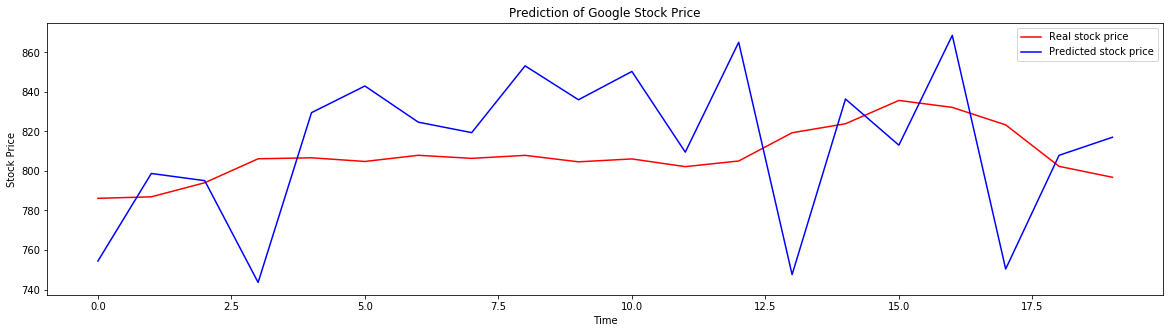

In [27]:
plt.figure(figsize=(20,5))
plt.plot(y_test, color='red', label = "Real stock price")
plt.plot(predicted, color='blue', label = "Predicted stock price")
plt.title("Prediction of Google Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## TESTING Test/Train Split LSTM

#### Here we decided to create a model that would use LSTM but for a longer period of time. In the first model we only used 20 days to predict however we decided here to split both the training model and test model into two pieces and create our prediction based on this. Given a longer period of time (148 days), we should hope to see a more accurate model than the first time. 

In [28]:
data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)



test_data = data[data['Date'] > '2016-06-01'].copy()



train_data = data[data['Date'] < '2016-06-01'].copy()

data

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0
...,...,...,...,...,...,...
1253,2016-12-23,790.90,792.74,787.28,789.91,623400.0
1254,2016-12-27,790.68,797.86,787.66,791.55,789100.0
1255,2016-12-28,793.70,794.23,783.20,785.05,1153800.0
1256,2016-12-29,783.33,785.93,778.92,782.79,744300.0


In [29]:
scaler = MinMaxScaler(feature_range=(0,1))

training_data = data.drop(['Date'], axis = 1)
training_data = scaler.fit_transform(training_data)

training_data

array([[0.08581368, 0.09640129, 0.09044931, 0.23757287, 0.29525831],
       [0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592],
       [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868]])

In [30]:
X_train = [] 
y_train = []

training_data.shape[0]

1258

In [31]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    y_train.append(training_data[i, 0])
    

In [32]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((1198, 60, 5), (1198,))

In [33]:
reg = Sequential()

reg.add(LSTM(units = 50,return_sequences = True,  input_shape=(X_train.shape[1], 5)))
reg.add(Dropout(0.2))


#Second LSTM Layer
reg.add(LSTM(units = 60, return_sequences = True))
reg.add(Dropout(0.3))

# Third LSTM Layer
reg.add(LSTM(units = 80, return_sequences = True))
reg.add(Dropout(0.4))

# Fourth LSTM Layer
reg.add(LSTM(units = 120))
reg.add(Dropout(0.5))


# The output layer
reg.add(Dense(units = 1))

reg.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

In [34]:
reg.compile(optimizer='adam', loss = 'mean_squared_error')

reg.fit(X_train, y_train, epochs=10,batch_size=32)


Epoch 1/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0385
Epoch 2/10
38/38 [==============================] - 3s 87ms/step - loss: 0.0080
Epoch 3/10
38/38 [==============================] - 5s 133ms/step - loss: 0.0082
Epoch 4/10
38/38 [==============================] - 6s 162ms/step - loss: 0.0066
Epoch 5/10
38/38 [==============================] - 6s 157ms/step - loss: 0.0088
Epoch 6/10
38/38 [==============================] - 3s 81ms/step - loss: 0.0071
Epoch 7/10
38/38 [==============================] - 3s 85ms/step - loss: 0.0068
Epoch 8/10
38/38 [==============================] - 3s 82ms/step - loss: 0.0065
Epoch 9/10
38/38 [==============================] - 3s 85ms/step - loss: 0.0063
Epoch 10/10
38/38 [==============================] - 3s 86ms/step - loss: 0.0054


In [35]:
test_data

past_60_days= train_data.tail(60)

df = past_60_days.append(test_data, ignore_index=True)

df = df.drop(['Date'], axis = 1)

In [36]:
inputs = scaler.transform(df)
inputs

array([[0.79578094, 0.79720619, 0.77602667, 0.28107989, 0.11923108],
       [0.76171962, 0.78917586, 0.77307168, 0.27943993, 0.0828354 ],
       [0.78009897, 0.79270547, 0.78947568, 0.29497127, 0.05661193],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868]])

In [37]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((148, 60, 5), (148,))

In [38]:
y_pred = reg.predict(X_test)

scaler.scale_

array([1.86025746e-03, 1.86751825e-03, 1.89422640e-03, 1.37811281e-03,
       4.00480577e-08])

In [39]:
scale = 1/1.86025746e-03
scale

537.5599998937781

# Visualize Results
#### This would be our ideal model. As we can see our prediction line didn't stay completely with the real stock price the entire time; however we were able to achieve the general shape of the curve which gives us a good estimate of what the stock price would be.

In [40]:
y_pred = y_pred*scale
y_test= y_test*scale

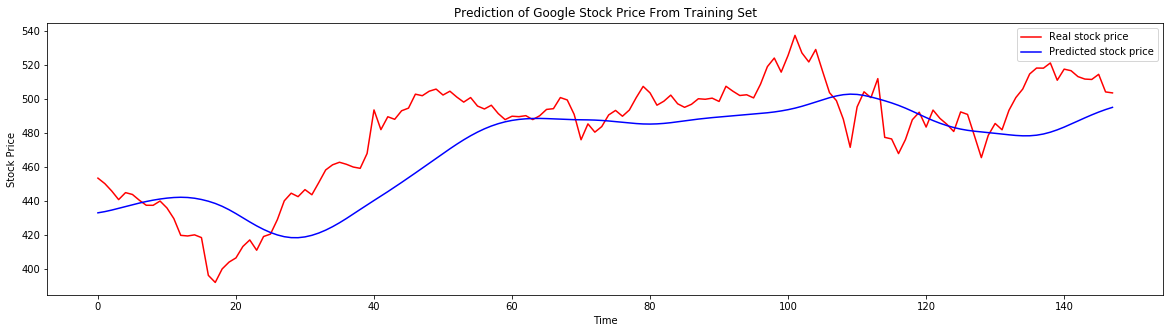

In [41]:
#Visualize Results
plt.figure(figsize=(20,5))
plt.plot(y_test, color='red', label = "Real stock price")
plt.plot(y_pred, color='blue', label = "Predicted stock price")
plt.title("Prediction of Google Stock Price From Training Set")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# CONCLUSION
#### Overall neither of our first two models were very accurate. This is most likely because stocks don’t have much to do with their features or data about the company; the price changes based on the demand of that stock. Our low accuracy could also be due to the limited features provided for the dataset; if we added more features about the company (revenue, profit) or percent increase on the overall stock market for that day it may become more accurate. After researching this problem, a better approach for predicting stock prices might be to use a technical analysis library (TA-lib) which does what our model does but includes many additional stock driven features. However, when we began to look at the prediction for a longer period of time like we did in our third model, we can see that it was much more accurate than before. This could be because according to the plot above, for ranges of some 20 days, the plots are off however when we look at the entire data and over a decent period of time it wass able to get the general shape of the curve for the prediction.
